# SDM1 : Montane woodcreper - Model

## Preparation

Start R in the bash terminal and run the following lines to install the libraries. 
 
     
    install.packages("e1071")
    install.packages("caret")
    install.packages("rworldmap")
    install.packages("maptools")
    install.packages("rgeos")
    install.packages("reshape")
    install.packages("randomForest")

In [1]:
library(ggplot2)
library(rgdal)
library(raster)
library(rgeos)
library(reshape)
library(rasterVis)
library(dismo)
library(InformationValue)
library(mgcv)
library(randomForest)
library(e1071)
library(caret)

Loading required package: sp
rgdal: version: 1.5-23, (SVN revision 1121)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.3.3, released 2018/12/14
Path to GDAL shared files: /home/user/miniconda3/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 5.2.0, September 15th, 2018, [PJ_VERSION: 520]
Path to PROJ shared files: /home/user/miniconda3/share/proj
Linking to sp version:1.4-5
rgeos version: 0.5-5, (SVN revision 640)
 GEOS runtime version: 3.7.1-CAPI-1.11.1 
 Linking to sp version: 1.4-5 
 Polygon checking: TRUE 

Loading required package: terra
terra version 1.1.4

NOTE: using GDAL version 2.3.3 
For full functionality you need at least version 3.0.4


Attaching package: ‘terra’

The following object is masked from ‘package:reshape’:

    expand

The following object is masked from ‘package:rgdal’:

    project

Loading required package: lattice
Loading required package: latticeExtra

Attaching package: ‘lattice

In [2]:
set.seed(30)

## Data Exploration

We will use Montane woodcreper (Lepidocolaptes lacrymiger) as example species. 

This species has a large range, occurring from the coastal cordillera of Venezuela along the Andes south to south-east Peru and central Bolivia.

<img src='../images/Montane_Woodcreeper.jpg' width="400">

### Read in points data 

## Load observation presence dataset

Let's suppose that you have done field work and you have collected the bird presence in the Lepidocolaptes_lacrymiger_allpoints.csv file

In [1]:
 points_field <- read.csv("./geodata/shp/Lepidocolaptes_lacrymiger_allpoints.csv")
 str(points_field)

'data.frame':	3438 obs. of  3 variables:
 $ lon            : num  -76.2 -76.2 -74.3 -74.3 -76.1 ...
 $ lat            : num  3.98 3.93 4.61 4.61 4.75 ...
 $ scientific_name: chr  "Lepidocolaptes_lacrymiger" "Lepidocolaptes_lacrymiger" "Lepidocolaptes_lacrymiger" "Lepidocolaptes_lacrymiger" ...


Morover you also download aditional points data from the https://www.gbif.org/ . 

In [3]:
# gbif_points = gbif('Lepidocolaptes' , 'lacrymiger' , download=T , geo=T , ext=c(-82,-59,-21,14) , removeZeros=TRUE )
# save(gbif_points , file="~/SE_data/exercise/geodata/SDM/gbif_points.Rdata")
load("./geodata/SDM/gbif_points.Rdata")
points=rbind.data.frame(
  data.frame(lat=gbif_points$lat,lon=gbif_points$lon),
  data.frame(lat=points_field$lat,lon=points_field$lon)
)
str(points)

'data.frame':	34835 obs. of  2 variables:
 $ lat: num  0.02978 5.3731 4.76848 0.00634 6.40736 ...
 $ lon: num  -78.7 -75.9 -75.5 -78.7 -75.7 ...


### Load the environmental data layers

In [4]:
rCld   <- raster("./geodata/cloud/SA_meanannual_crop_msk.tif")
# compute min and max
rCld   =  setMinMax(rCld)
rCldIA <- raster("./geodata/cloud/SA_intra_crop_msk.tif")
rCldIA =  setMinMax(rCldIA)
rElv   <- raster("./geodata/dem/SA_elevation_mn_GMTED2010_mn_crop_msk.tif")
rElv   =  setMinMax(rElv)
rVeg   <- raster("./geodata/vegetation/SA_tree_mn_percentage_GFC2013_crop_msk.tif")
rVeg   =  setMinMax(rVeg)
rElv

ERROR: Error in raster("./geodata/cloud/SA_meanannual_crop_msk.tif"): could not find function "raster"


### Load expert range map 

In [6]:
birdrange <- readOGR("./geodata/shp", "cartodb-query")

OGR data source with driver: ESRI Shapefile 
Source: "/media/sf_LVM_shared/my_SE_data/exercise/geodata/shp", layer: "cartodb-query"
with 2 features
It has 7 fields


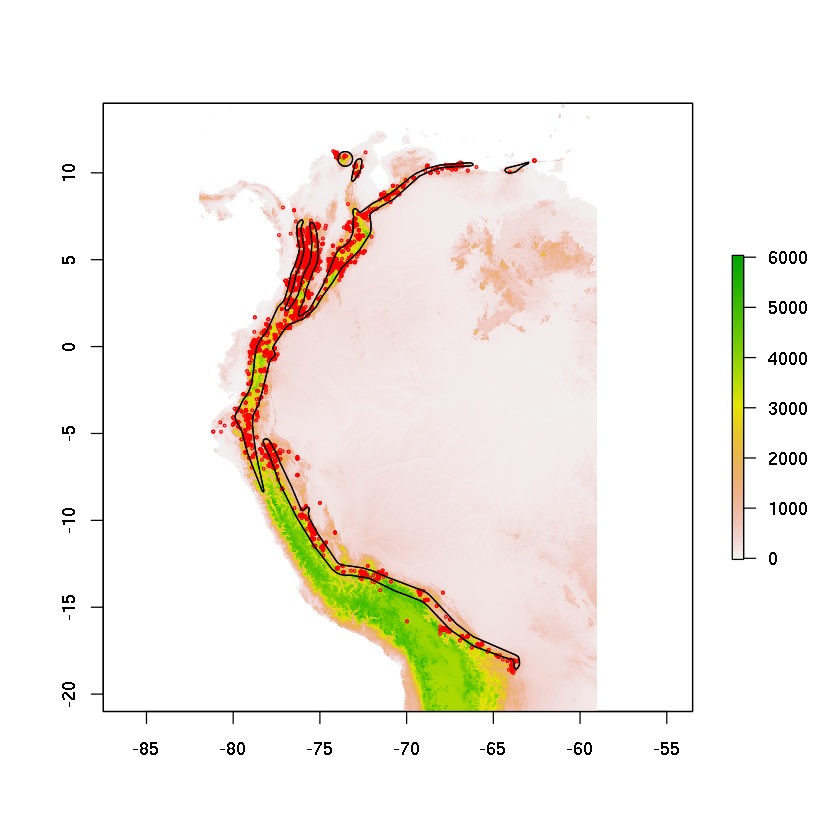

In [7]:
plot(rElv)
points(points$lon, points$lat, col = "red", cex = .3)
plot(birdrange,add=TRUE)

In [8]:
# indicate that these data are presences
presence <- matrix(1,nrow(points),1)
points <- cbind(points,presence)

In [9]:
head(points)

lat,lon,presence
0.029785,-78.68224,1
5.373100,-75.89100,1
4.768477,-75.45283,1
0.006336,-78.67635,1
6.407356,-75.66417,1
11.107720,-74.04844,1


In [10]:
# building spatial dataframe
coordinates(points)=c('lon','lat')

In [11]:
str(points)

Formal class 'SpatialPointsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	34835 obs. of  1 variable:
  .. ..$ presence: num [1:34835] 1 1 1 1 1 1 1 1 1 1 ...
  ..@ coords.nrs : int [1:2] 2 1
  ..@ coords     : num [1:34835, 1:2] -78.7 -75.9 -75.5 -78.7 -75.7 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:2] "lon" "lat"
  ..@ bbox       : num [1:2, 1:2] -81.1 -18.8 -62.6 11.2
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:2] "lon" "lat"
  .. .. ..$ : chr [1:2] "min" "max"
  ..@ proj4string:Formal class 'CRS' [package "sp"] with 1 slot
  .. .. ..@ projargs: chr NA


In [12]:
# assign projection
projection(points) <- "+proj=longlat +datum=WGS84" 

Loading eBird sampling dataset, in order to obtain “absence” data

In [13]:
# link to global sampling raster
# first crop with the gdal and then load the cropversion
system("gdal_translate -projwin -82 14 -59 -21 -co COMPRESS=DEFLATE -co ZLEVEL=9 ./geodata/SDM/eBirdSampling_filtered.tif ./geodata/SDM/eBirdSampling_filtered_crop.tif")
gsampling <- raster("./geodata/SDM/eBirdSampling_filtered_crop.tif")

In [14]:
# assign projection
projection(gsampling)="+proj=longlat +datum=WGS84"
gsampling

class      : RasterLayer 
dimensions : 4200, 2760, 11592000  (nrow, ncol, ncell)
resolution : 0.008333333, 0.008333333  (x, y)
extent     : -82, -59, -20.99999, 14  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0 
source     : /media/sf_LVM_shared/my_SE_data/exercise/geodata/SDM/eBirdSampling_filtered_crop.tif 
names      : eBirdSampling_filtered_crop 
values     : 0, 65535  (min, max)


In [15]:
# convert to points within data region
samplingp <- as(gsampling,"SpatialPointsDataFrame")
samplingp <- samplingp[samplingp$eBirdSampling_filtered_crop>0,]
str(samplingp)
head(samplingp)

Formal class 'SpatialPointsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	17420 obs. of  1 variable:
  .. ..$ eBirdSampling_filtered_crop: num [1:17420] 1 2 1 2 1 1 1 4 1 2 ...
  ..@ coords.nrs : num(0) 
  ..@ coords     : num [1:17420, 1:2] -61 -61 -61 -61 -61 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:2] "x" "y"
  ..@ bbox       : num [1:2, 1:2] -82 -21 -59 14
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:2] "x" "y"
  .. .. ..$ : chr [1:2] "min" "max"
  ..@ proj4string:Formal class 'CRS' [package "sp"] with 1 slot
  .. .. ..@ projargs: chr "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"


,eBirdSampling_filtered_crop
2518,1
2519,2
2520,1
2523,2
2525,1
2529,1


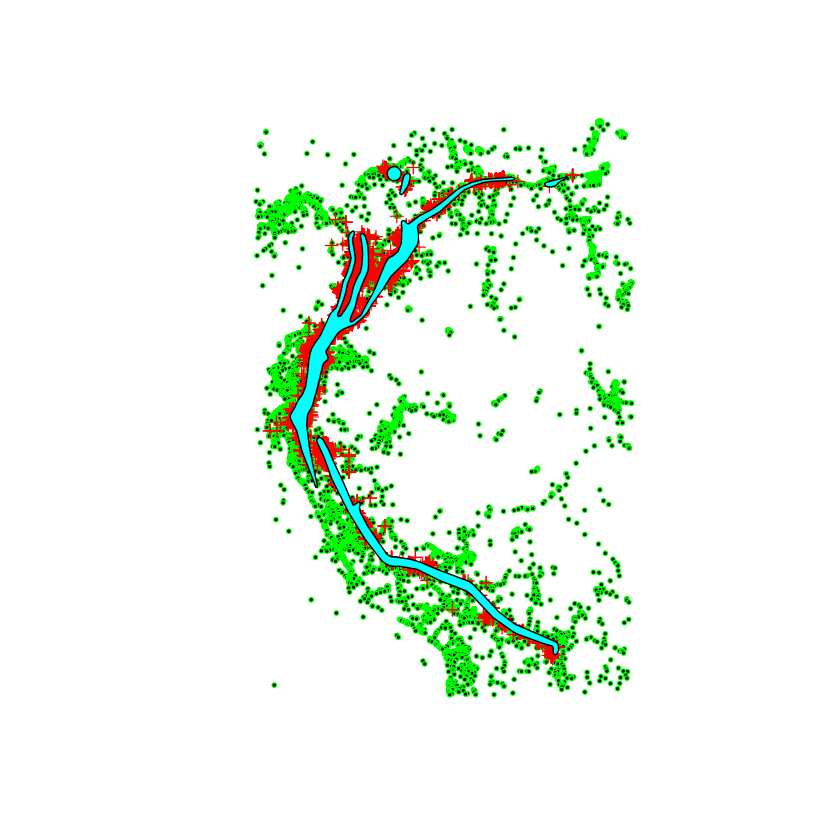

In [16]:
 # edit column names
 colnames(samplingp@data) <- c("observation")
 samplingp$presence=0
 plot(samplingp, col="green",pch=21,cex=.5)#absences
 plot(points, col="red",add=TRUE)#presences
 plot(birdrange, col="cyan",add=TRUE)#species range

In [17]:
summary(samplingp)

Object of class SpatialPointsDataFrame
Coordinates:
        min       max
x -81.97917 -59.00417
y -20.99583  13.99584
Is projected: FALSE 
proj4string :
[+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0]
Number of points: 17420
Data attributes:
  observation          presence
 Min.   :   1.000   Min.   :0  
 1st Qu.:   1.000   1st Qu.:0  
 Median :   2.000   Median :0  
 Mean   :   5.935   Mean   :0  
 3rd Qu.:   3.000   3rd Qu.:0  
 Max.   :1412.000   Max.   :0  

combine presence and non-presence point datasets

In [18]:
pdata <- rbind(points[,"presence"],samplingp[,"presence"])
pdata@data[,c("lon","lat")] <- coordinates(pdata)
table(pdata$presence)


    0     1 
17420 34835 

### Plot the environmental data layers

In [19]:
env <- stack(c(rCld,rCldIA,rElv,rVeg))
env

class      : RasterStack 
dimensions : 4200, 2760, 11592000, 4  (nrow, ncol, ncell, nlayers)
resolution : 0.008333333, 0.008333333  (x, y)
extent     : -82, -59, -21, 14  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
names      : SA_meanannual_crop_msk, SA_intra_crop_msk, SA_elevation_mn_GMTED2010_mn_crop_msk, SA_tree_mn_percentage_GFC2013_crop_msk 
min values :                    859,                 0,                                   -72,                                      0 
max values :                  10000,              3790,                                  6460,                                  10000 


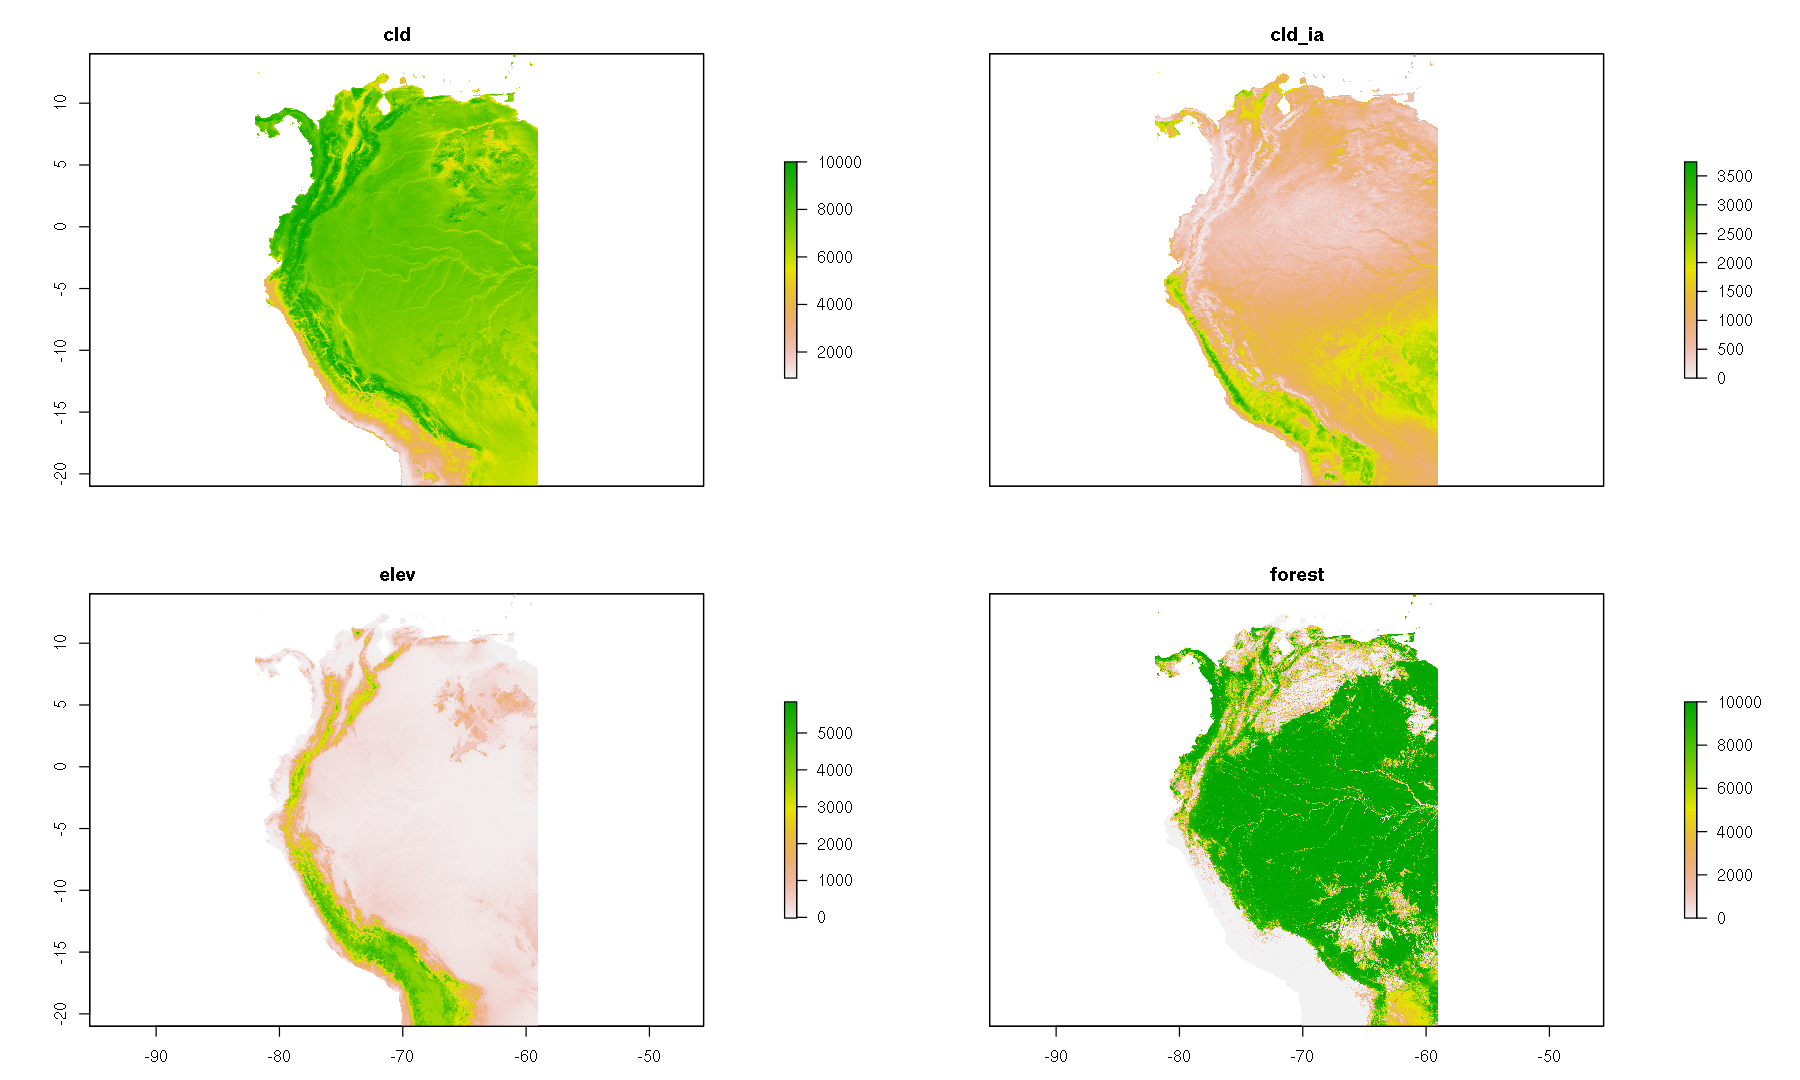

In [20]:
# rename layers for convenience
vars <- c("cld","cld_ia","elev","forest")

names(env) <- vars
 
# visual result 
options(repr.plot.width=15, repr.plot.height=9)
 # check out the plot
plot(env)

Scaling and centering the environmental variables to zero mean and variance of 1

In [21]:
senv <- scale(env[[vars]])
senv
# this operation is quite long. Would be possible to do in gdal? how?

class      : RasterBrick 
dimensions : 4200, 2760, 11592000, 4  (nrow, ncol, ncell, nlayers)
resolution : 0.008333333, 0.008333333  (x, y)
extent     : -82, -59, -21, 14  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : /tmp/Rtmpmz1dGG/raster/r_tmp_2021-04-20_190050_14811_30290.grd 
names      :        cld,     cld_ia,       elev,     forest 
min values : -4.5919892, -1.7513057, -0.6661006, -1.7261695 
max values :  2.1937157,  4.5331428,  5.0445753,  0.7798705 


Warning message in .hist1(raster(x, y[i]), maxpixels = maxpixels, main = main[y[i]], :
“1% of the raster cells were used. 100000 values used.”Warning message in .hist1(raster(x, y[i]), maxpixels = maxpixels, main = main[y[i]], :
“1% of the raster cells were used. 100000 values used.”Warning message in .hist1(raster(x, y[i]), maxpixels = maxpixels, main = main[y[i]], :
“1% of the raster cells were used. 100000 values used.”Warning message in .hist1(raster(x, y[i]), maxpixels = maxpixels, main = main[y[i]], :
“1% of the raster cells were used. 100000 values used.”Warning message in .hist1(raster(x, y[i]), maxpixels = maxpixels, main = main[y[i]], :
“1% of the raster cells were used. 100000 values used.”Warning message in .hist1(raster(x, y[i]), maxpixels = maxpixels, main = main[y[i]], :
“1% of the raster cells were used. 100000 values used.”Warning message in .hist1(raster(x, y[i]), maxpixels = maxpixels, main = main[y[i]], :
“1% of the raster cells were used. 100000 values used.”Warnin

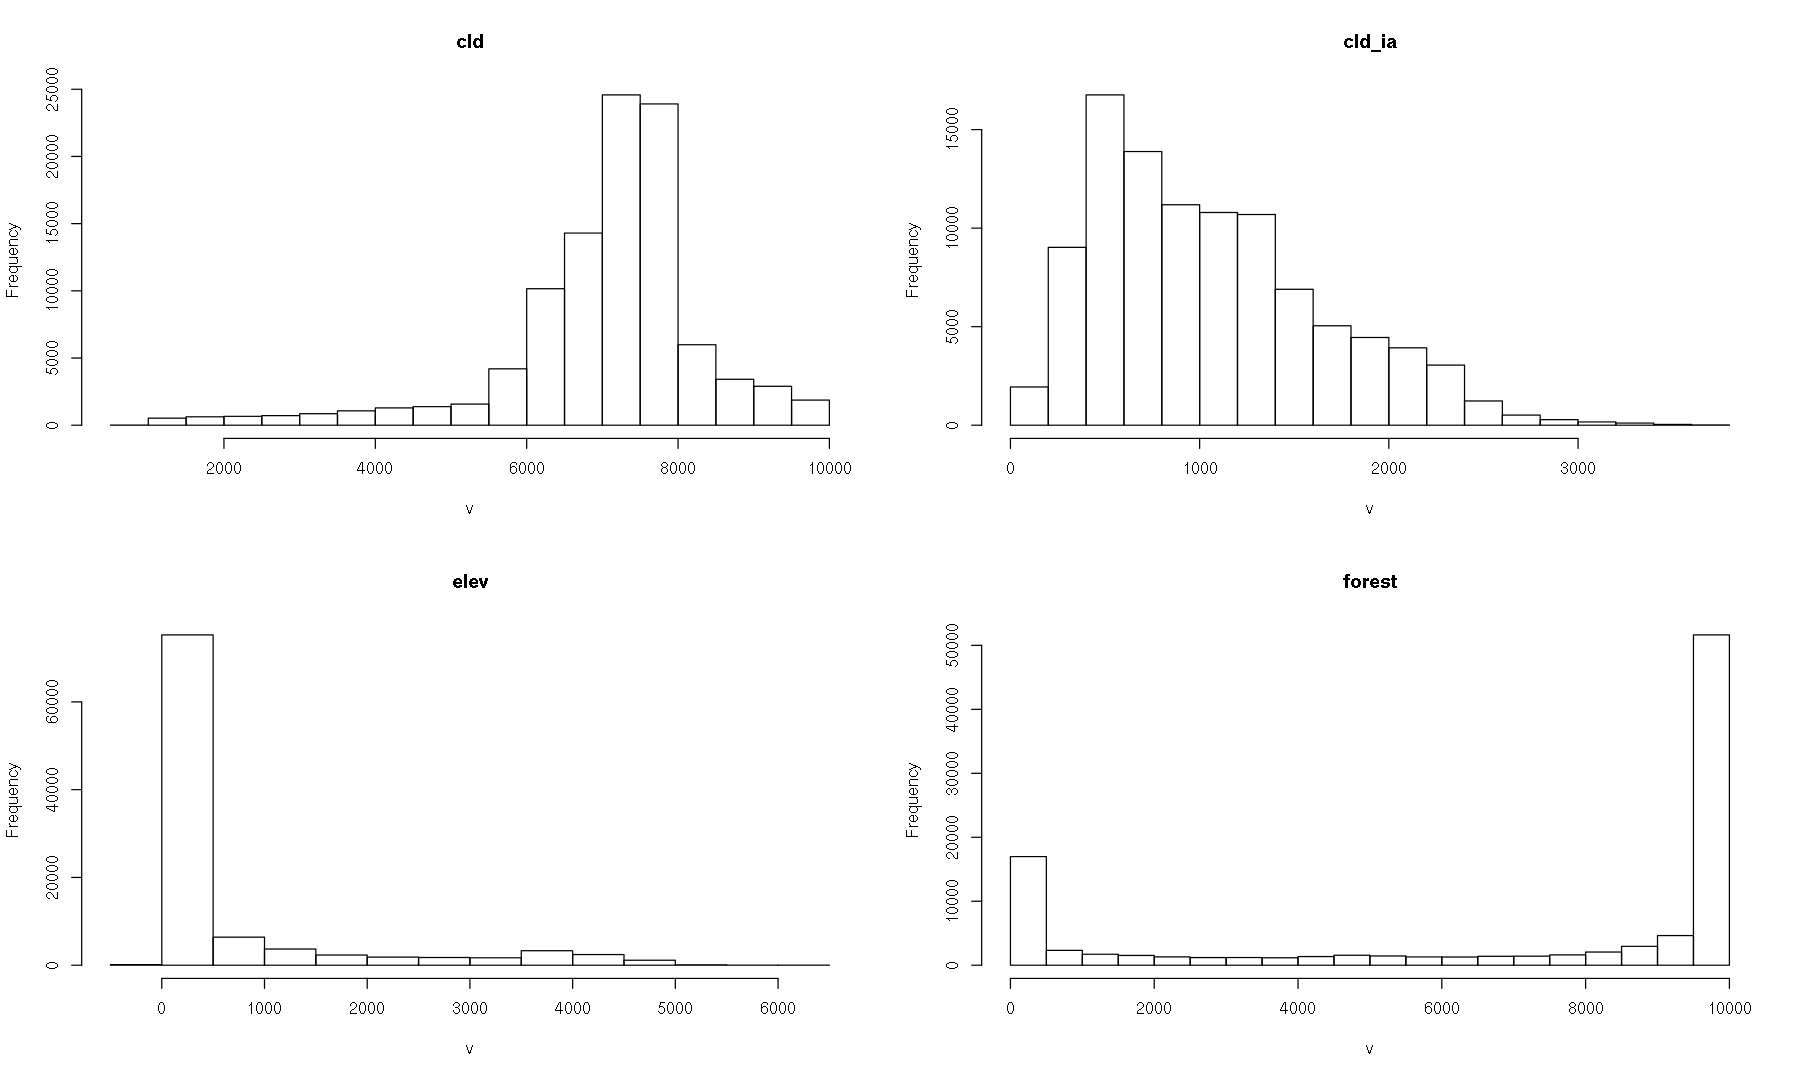

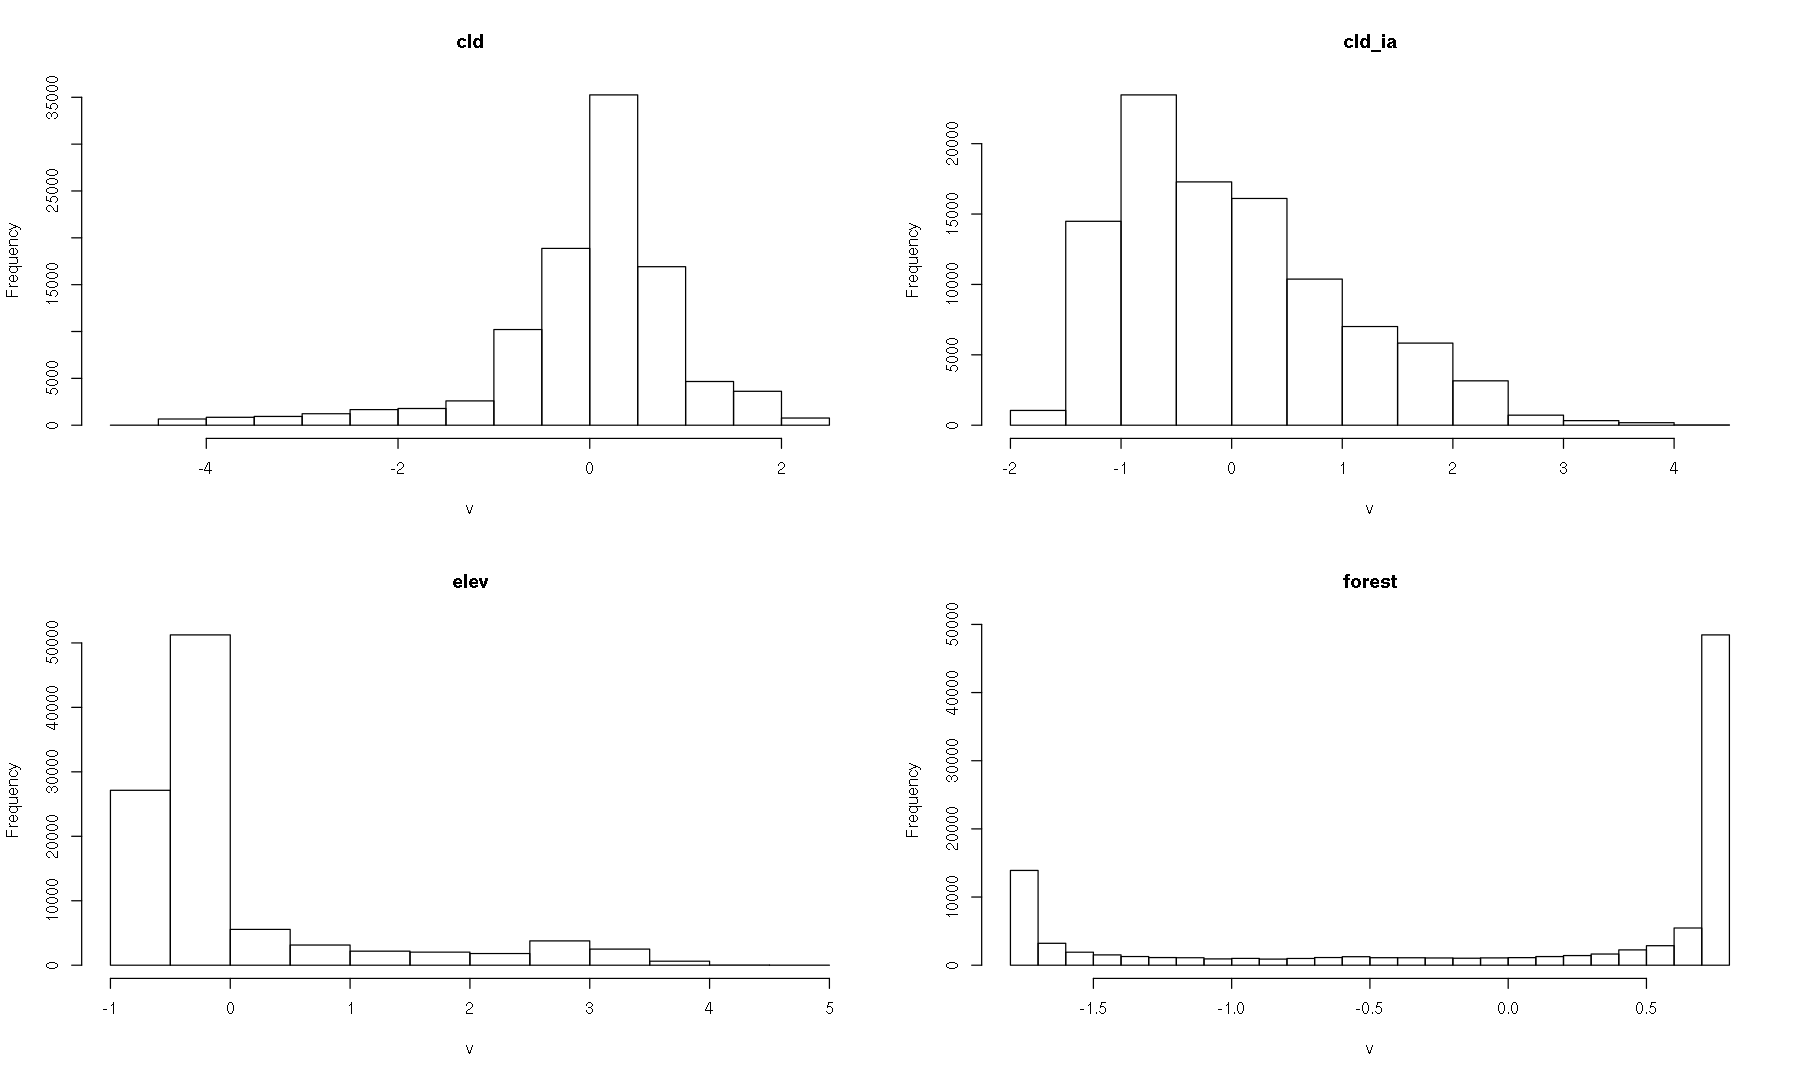

In [22]:
hist(env)
hist(senv)

Annotate the point records with the scaled environmental data

In [23]:
df.xact <- raster::extract(senv,pdata,sp=T) 

In [24]:
df.xact <- (df.xact[! is.na(df.xact$forest),])

### Correlation plots

In [25]:
## convert to 'long' format for easier plotting
df.xactl <- reshape::melt(df.xact@data,id.vars=c("lat","lon","presence"),variable.name="variable")

In [26]:
head(df.xactl)

lat,lon,presence,variable,value
0.029785,-78.68224,1,cld,1.927959
5.373100,-75.89100,1,cld,1.966560
4.768477,-75.45283,1,cld,2.029659
0.006336,-78.67635,1,cld,1.997739
6.407356,-75.66417,1,cld,1.138112
11.107720,-74.04844,1,cld,1.684472


In [27]:
tail(df.xactl)

,lat,lon,presence,variable,value
207399,-20.97083,-70.13750,0,forest,-1.726169
207400,-20.97083,-68.56250,0,forest,-1.726169
207401,-20.97916,-70.15417,0,forest,-1.726169
207402,-20.98749,-68.55417,0,forest,-1.726169
207403,-20.99583,-70.13750,0,forest,-1.726169
207404,-20.99583,-67.42917,0,forest,-1.726169


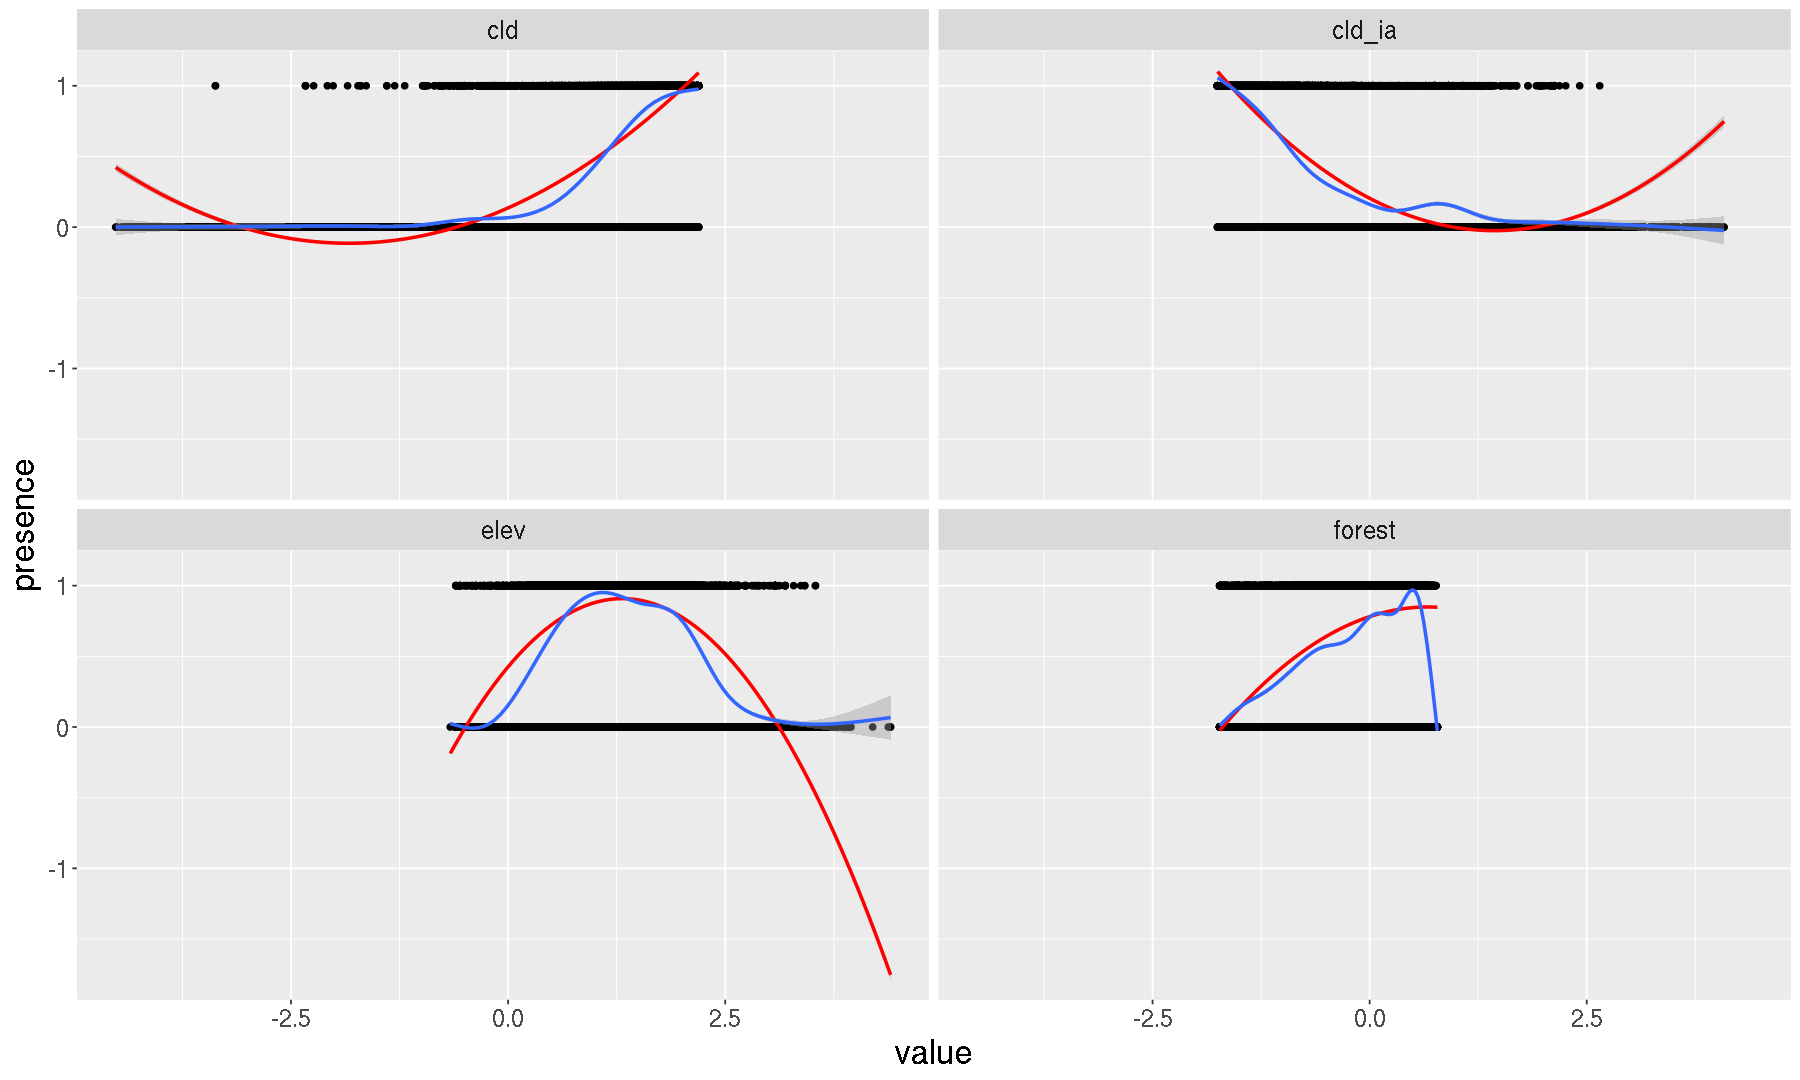

In [28]:
ggplot(df.xactl,aes(x=value,y=presence))+facet_wrap(~variable)+
  geom_point()+
  stat_smooth(method = "lm", formula = y ~ x + I(x^2), col="red")+
  geom_smooth(method="gam",formula=y ~ s(x, bs = "cs")) + 
  theme(text = element_text(size = 20))  

### Model Fitting


cross validation 


<img src='../images/cross_vld.gif' width="600">

In [29]:
df.xact <- as.data.frame(df.xact)

In [30]:
df.xact$grp <- kfold(df.xact,2)

In [31]:
head(df.xact)

presence,lon,lat,cld,cld_ia,elev,forest,lon.1,lat.1,grp
1,-78.68224,0.029785,1.927959,-1.4047492,0.7799278,0.2916939,-78.68224,0.029785,2
1,-75.89100,5.373100,1.966560,-1.5490096,0.9285523,0.4776421,-75.89100,5.373100,2
1,-75.45283,4.768477,2.029659,-1.4279635,3.0433908,-1.4251941,-75.45283,4.768477,2
1,-78.67635,0.006336,1.997739,-1.4097236,1.0081102,0.4074729,-78.67635,0.006336,2
1,-75.66417,6.407356,1.138112,-0.8791106,1.6227160,-0.6916761,-75.66417,6.407356,1
1,-74.04844,11.107720,1.684472,-1.0664833,1.5134332,-0.6926786,-74.04844,11.107720,1


In [32]:
mdl.glm <- glm(presence~cld+cld_ia*I(cld_ia^2)+elev*I(elev^2)+forest, family=binomial(link=logit), data=subset(df.xact,grp==1))

In [33]:
summary(mdl.glm)


Call:
glm(formula = presence ~ cld + cld_ia * I(cld_ia^2) + elev * 
    I(elev^2) + forest, family = binomial(link = logit), data = subset(df.xact, 
    grp == 1))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0094  -0.0254   0.2207   0.3529   3.7362  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -3.12534    0.09761 -32.020  < 2e-16 ***
cld                 1.07658    0.07419  14.512  < 2e-16 ***
cld_ia              0.36013    0.08632   4.172 3.02e-05 ***
I(cld_ia^2)         0.33685    0.03352  10.050  < 2e-16 ***
elev                5.89509    0.21499  27.420  < 2e-16 ***
I(elev^2)          -2.96605    0.18242 -16.259  < 2e-16 ***
forest              1.14142    0.04212  27.097  < 2e-16 ***
cld_ia:I(cld_ia^2) -0.18557    0.02972  -6.244 4.27e-10 ***
elev:I(elev^2)      0.34195    0.04548   7.519 5.50e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial fam

### Prediction

Calculate estimates of p(occurrence) for each cell.
We can use the predict function in the raster package to make the predictions across the full raster grid and save the output.

In [34]:
pred.glm1 <- predict(mdl.glm,df.xact[which(df.xact$grp==1),vars],type="response")
pred.glm2 <- predict(mdl.glm,df.xact[which(df.xact$grp==2),vars],type="response")

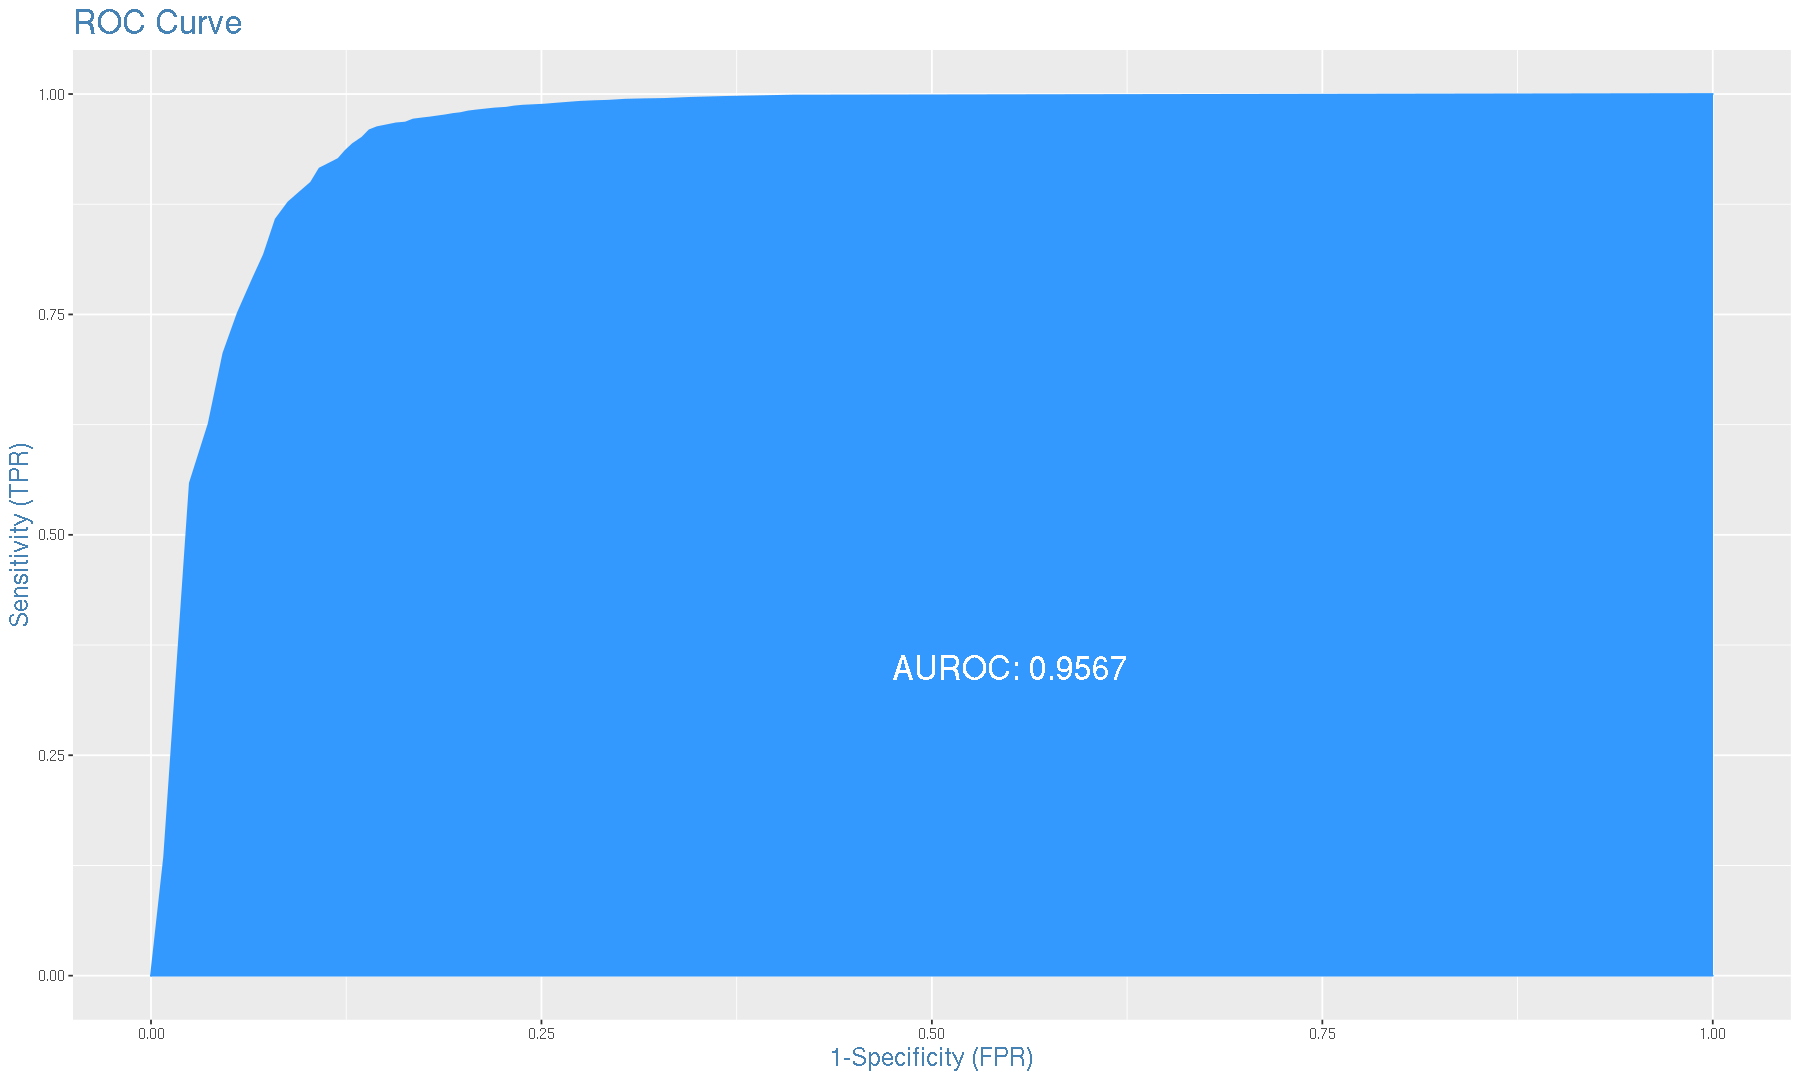

In [35]:
plotROC(df.xact[which(df.xact$grp==1),"presence"],pred.glm1)

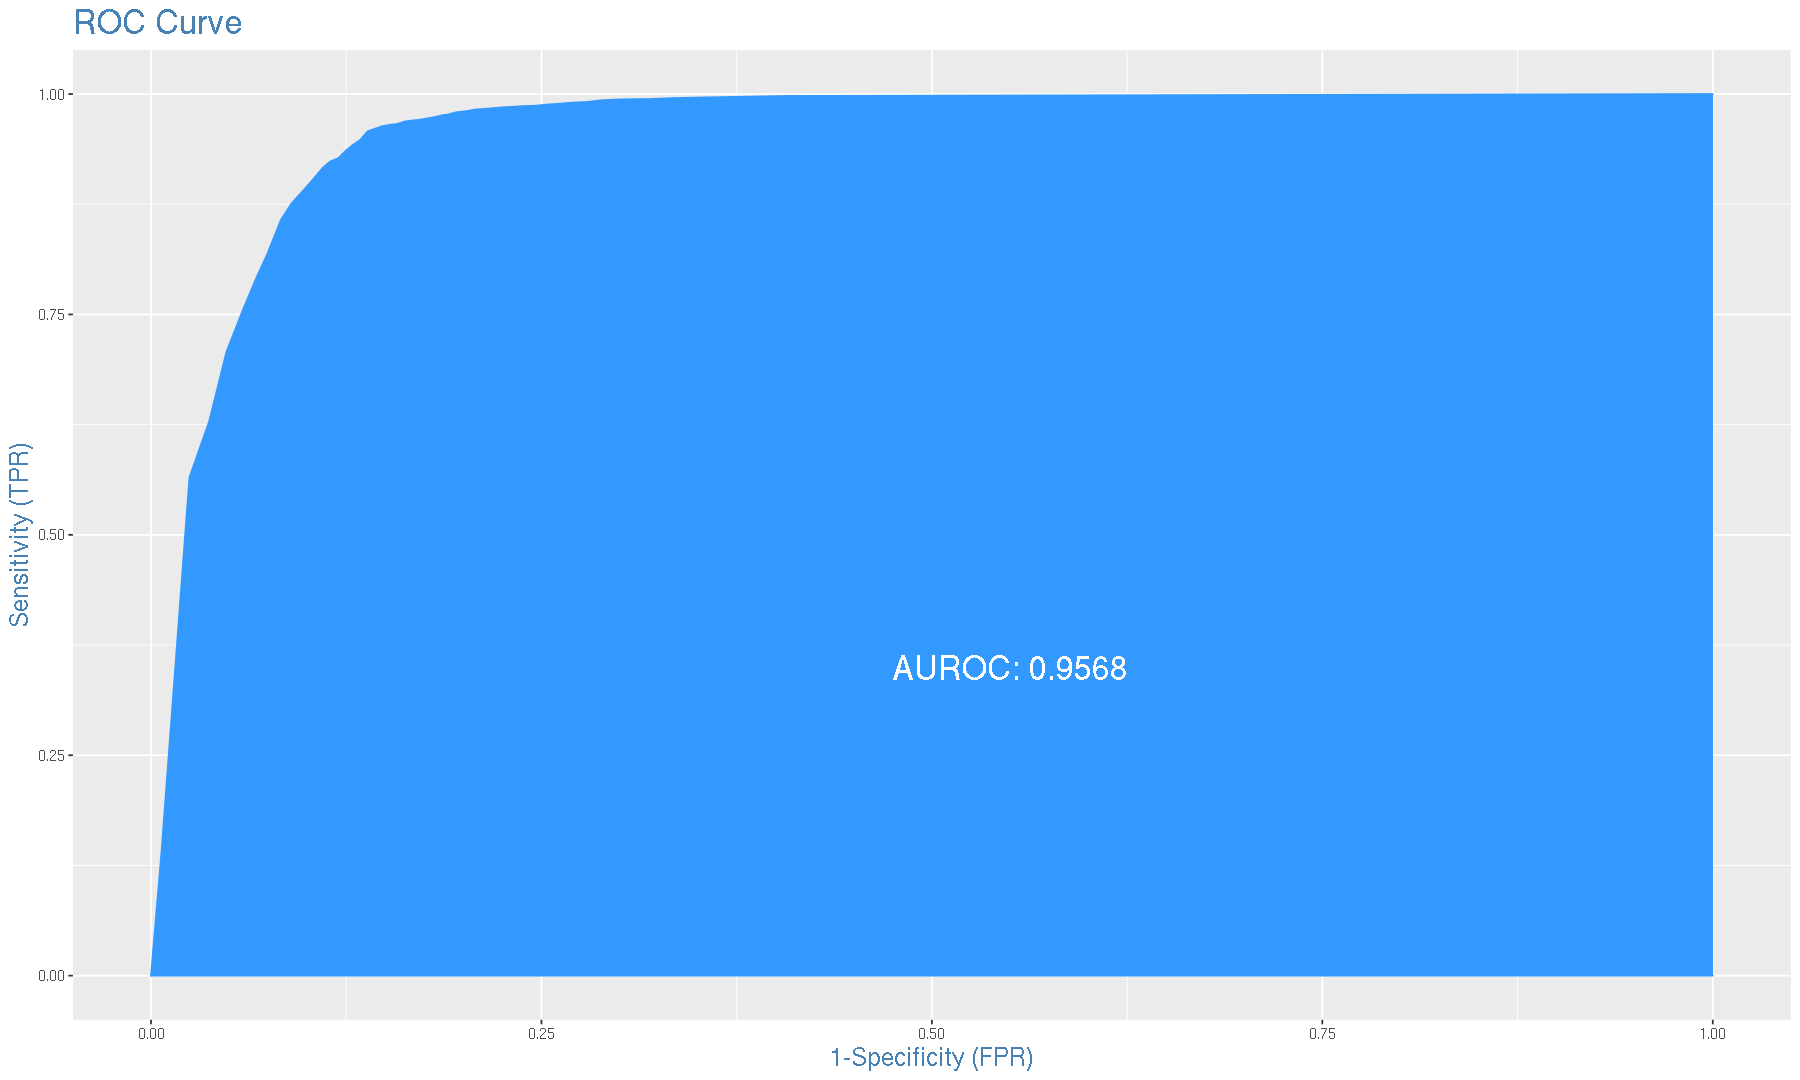

In [36]:
plotROC(df.xact[which(df.xact$grp==2),"presence"],pred.glm2)

### Out mapping

In [37]:
p1 <- raster::predict(senv,mdl.glm,type="response")

Plot the results as a map:

Regions defined for each Polygons


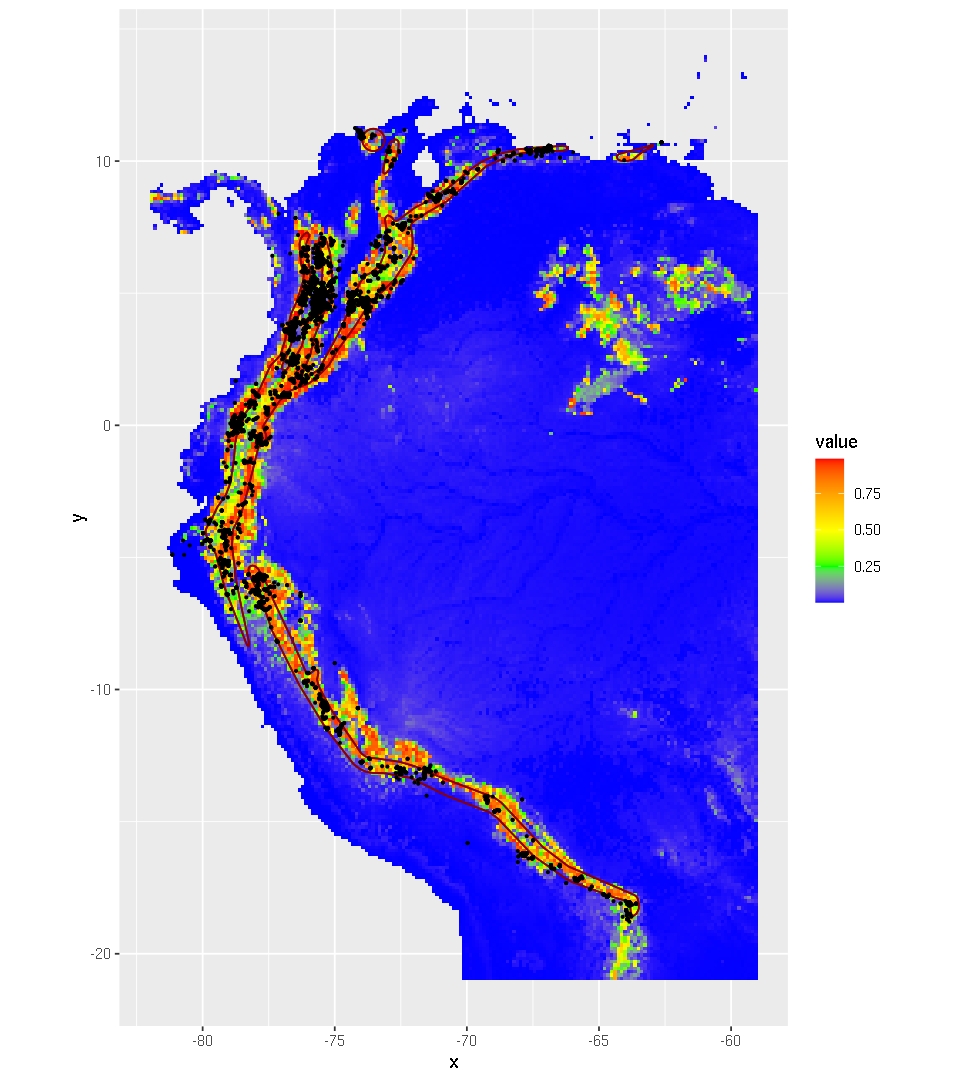

In [38]:
options(repr.plot.width=8, repr.plot.height=9)
gplot(p1)+geom_tile(aes(fill=value))+
  scale_fill_gradientn(
    colours=c("blue","green","yellow","orange","red"),
    na.value = "transparent")+
  geom_polygon(aes(x=long,y=lat,group=group),
               data=fortify(birdrange),fill="transparent",col="darkred")+
  geom_point(aes(x = lon, y = lat), data = subset(df.xact,presence==1),col="black",size=0.5)+
  coord_equal()

## Cross Validation

The library caret allow an easy implementation of the Cross Validation for several models.

In [39]:
ctrl <- trainControl(method = "cv", number = 10)

mdl.glm.cv <- train(  as.factor(presence) ~cld+cld_ia*I(cld_ia^2)+elev*I(elev^2)+forest, 
family=binomial(link=logit),  data = df.xact, method = "glm", trControl = ctrl, metric='Accuracy')

In [40]:
mdl.glm.cv

Generalized Linear Model 

51851 samples
    4 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 46665, 46666, 46666, 46667, 46667, 46666, ... 
Resampling results:

  Accuracy   Kappa    
  0.9235502  0.8210051


Predict in terms of presence/absence

In [41]:
pred.mdl.glm.cv.raw <- raster::predict(senv,mdl.glm.cv ,type="raw")

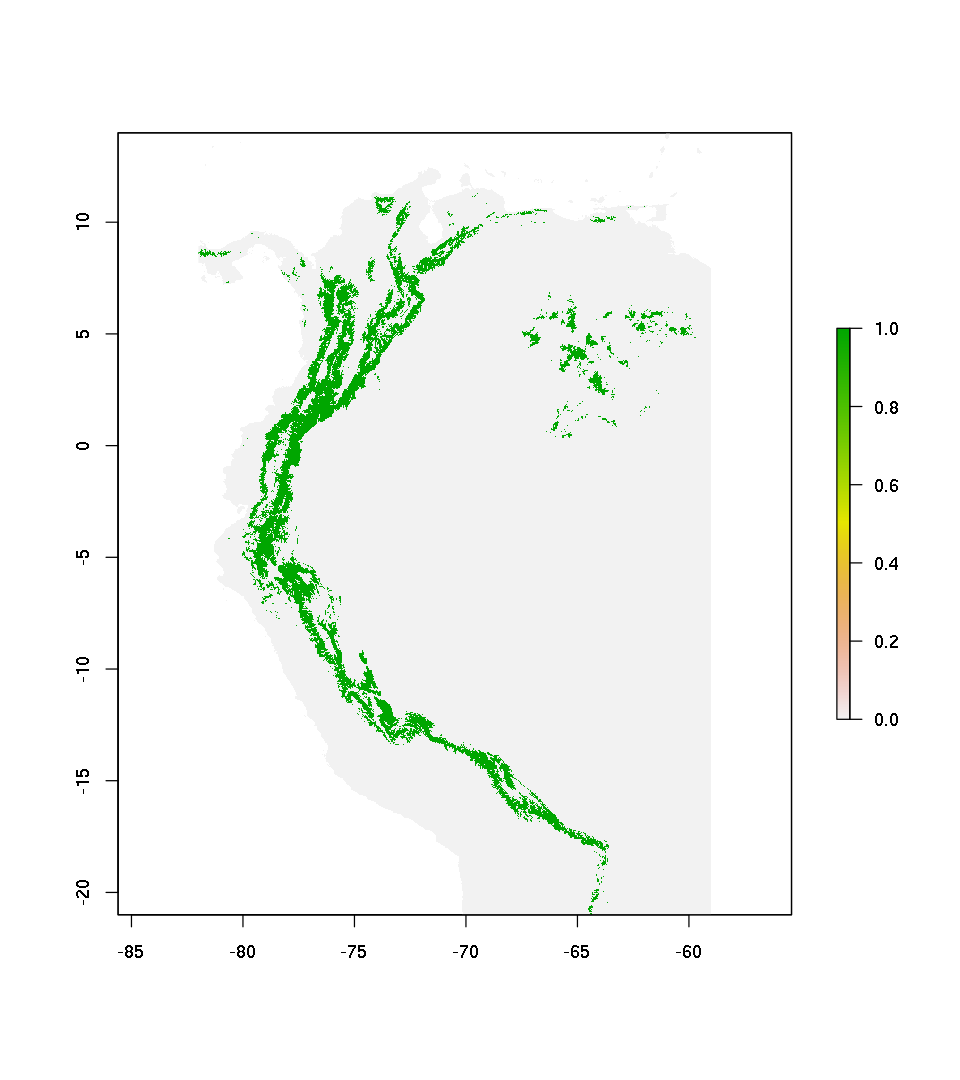

In [42]:
plot(pred.mdl.glm.cv.raw)

Predict and ploting in terms of probability

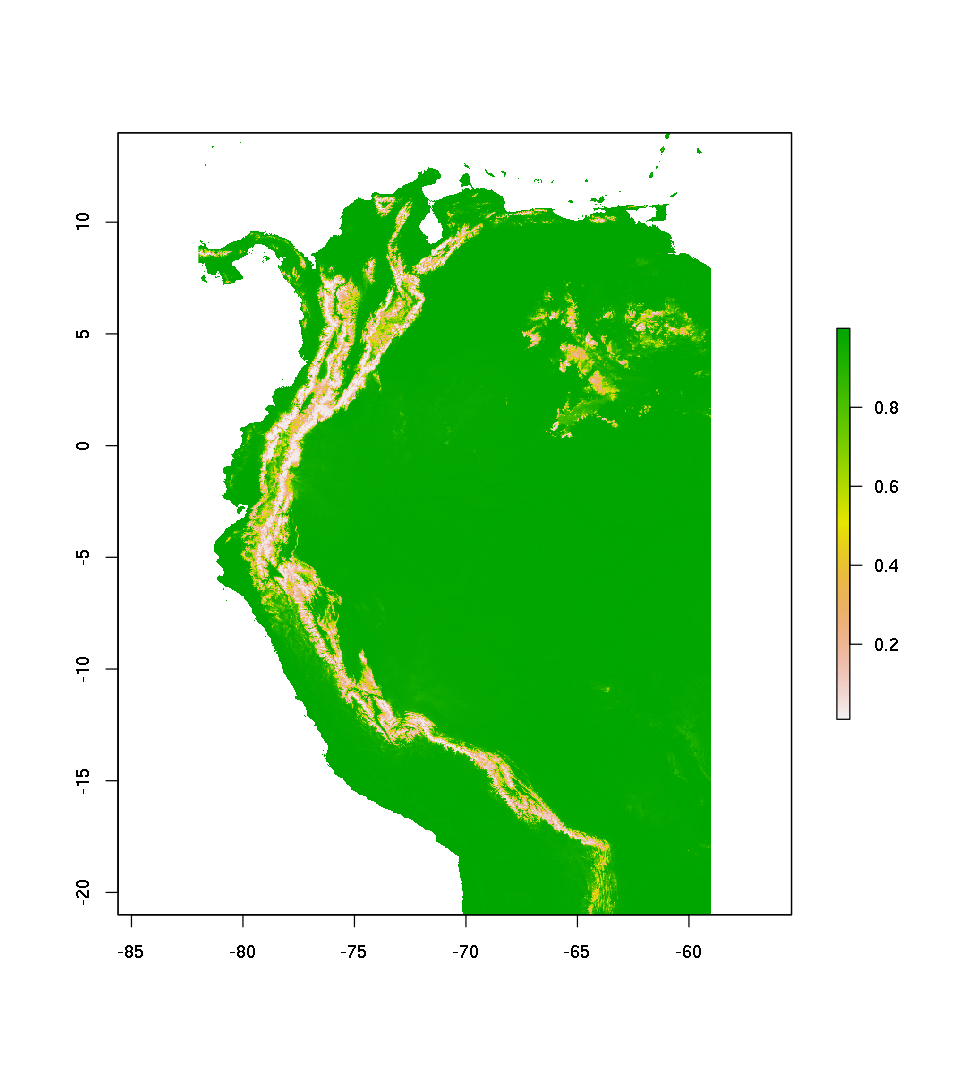

In [63]:
pred.mdl.glm.cv.prob1 <- raster::predict(senv,mdl.glm.cv ,type="prob" , index=1)
plot(pred.mdl.glm.cv.prob1)

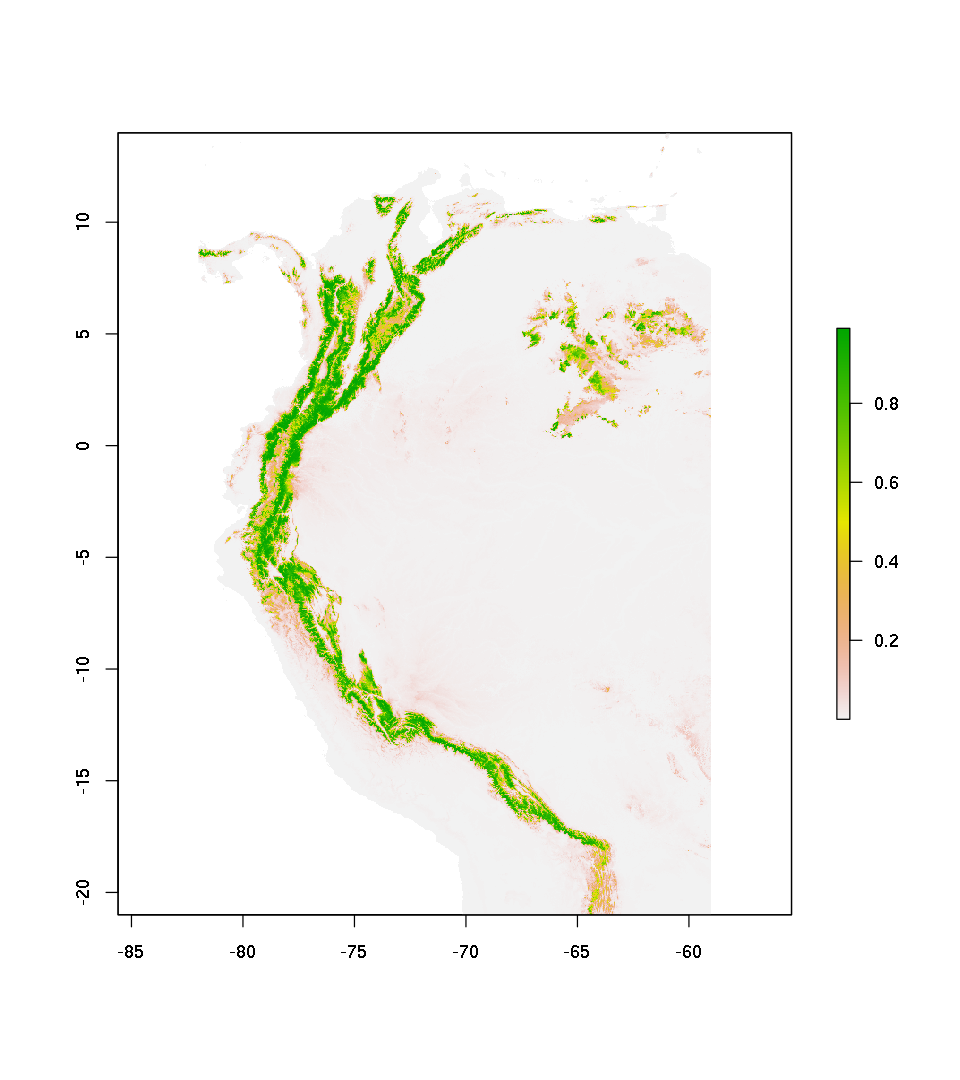

In [64]:
pred.mdl.glm.cv.prob2 <- raster::predict(senv,mdl.glm.cv ,type="prob" , index=2)
plot(pred.mdl.glm.cv.prob2)

## References

- https://en.wikipedia.org/wiki/Cross-validation

## Random Forest model

Random Forest is an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees (source https://en.wikipedia.org/wiki/Random_forest) 

The randomForest packages (https://cran.r-project.org/web/packages/randomForest/index.html) allows to run reggression or classification case in R.
(check also ranger: A Fast Implementation of Random Forests  https://cran.r-project.org/web/packages/ranger/index.html )

In [44]:
mdl.rf <- randomForest(as.factor(presence) ~ cld + cld_ia + elev +forest, data=subset(df.xact,grp==1))

In [45]:
mdl.rf


Call:
 randomForest(formula = as.factor(presence) ~ cld + cld_ia + elev +      forest, data = subset(df.xact, grp == 1)) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 6.46%
Confusion matrix:
     0     1 class.error
0 7446  1119  0.13064799
1  557 16804  0.03208341

### Predict as presence / absence

In [46]:
pred.rf.resp  <- raster::predict(senv , mdl.rf , type='response')

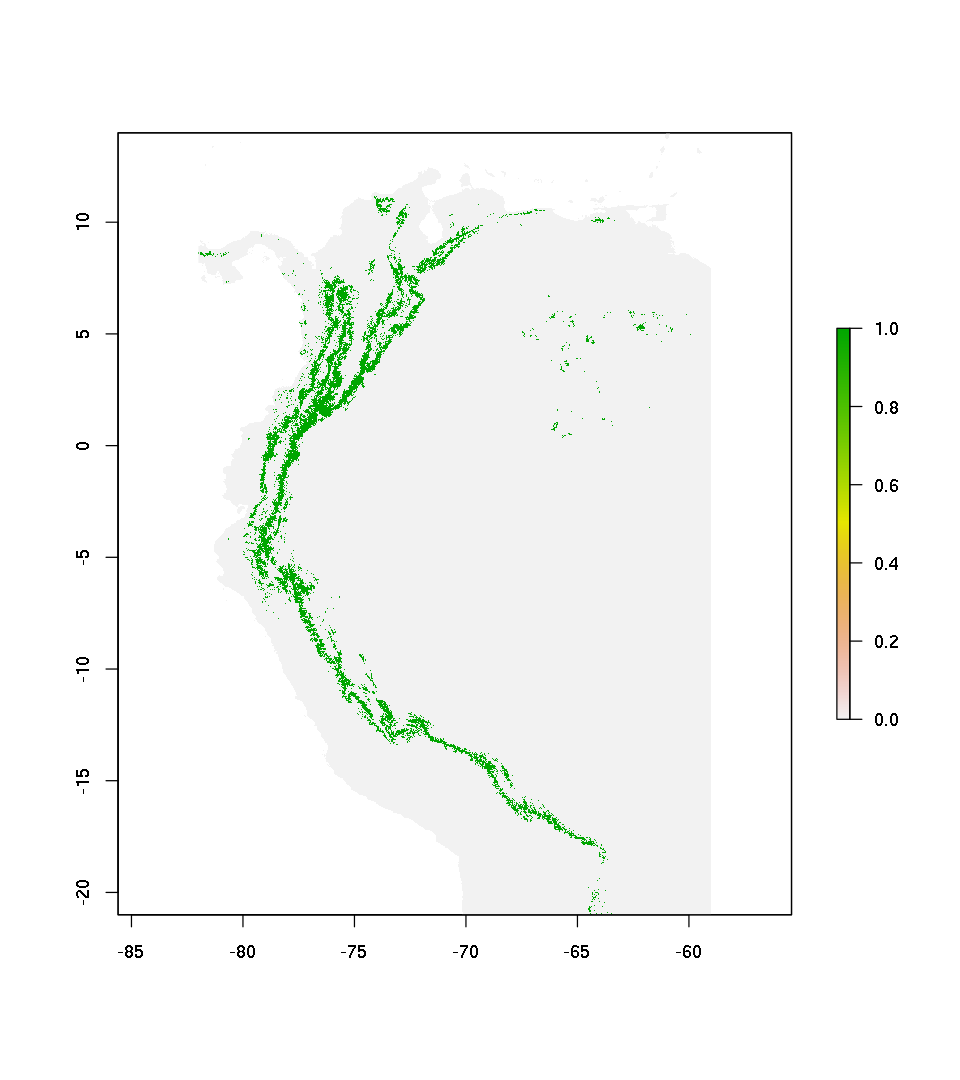

In [47]:
plot(pred.rf.resp)

### Predict as probability of presence / absence

In [62]:
pred.rf.prob1 <- raster::predict(senv , mdl.rf , type='prob' , index=1)   
pred.rf.prob0 <- raster::predict(senv , mdl.rf , type='prob' , index=2)

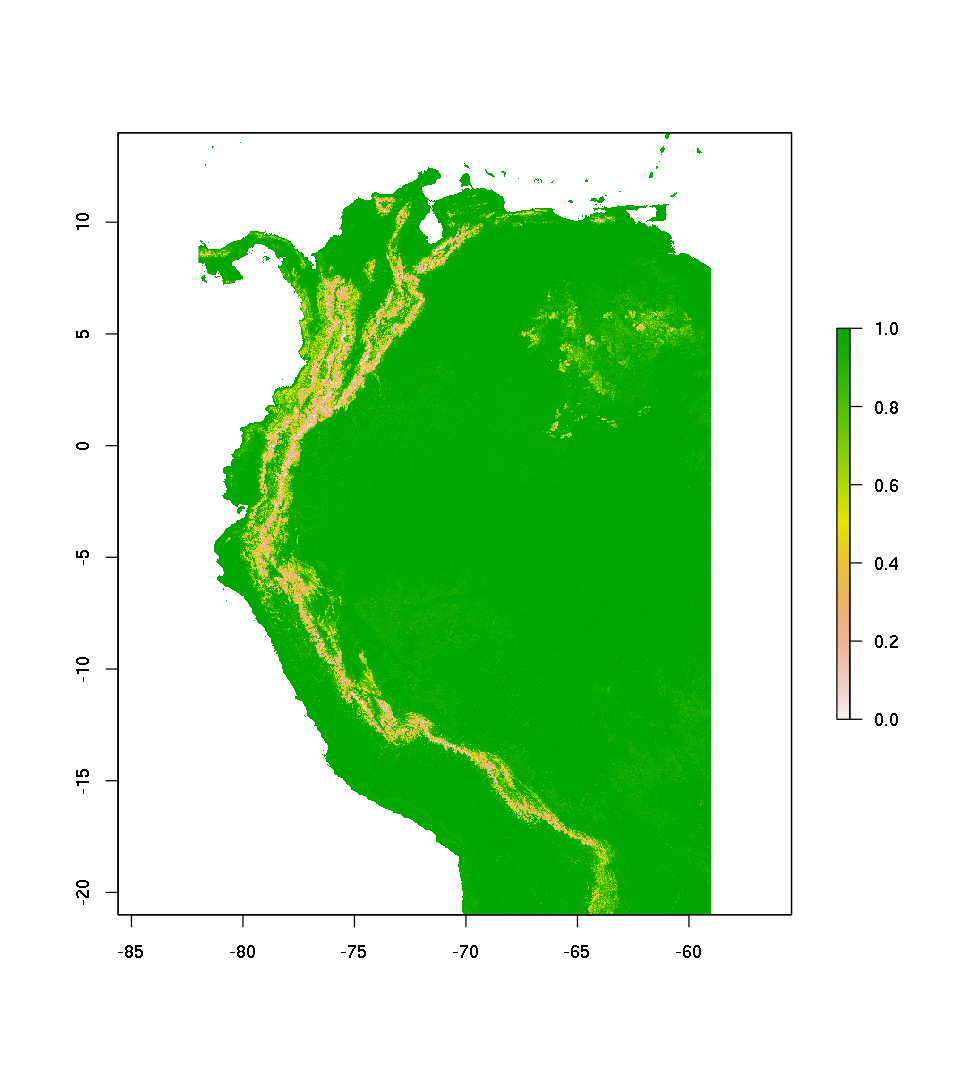

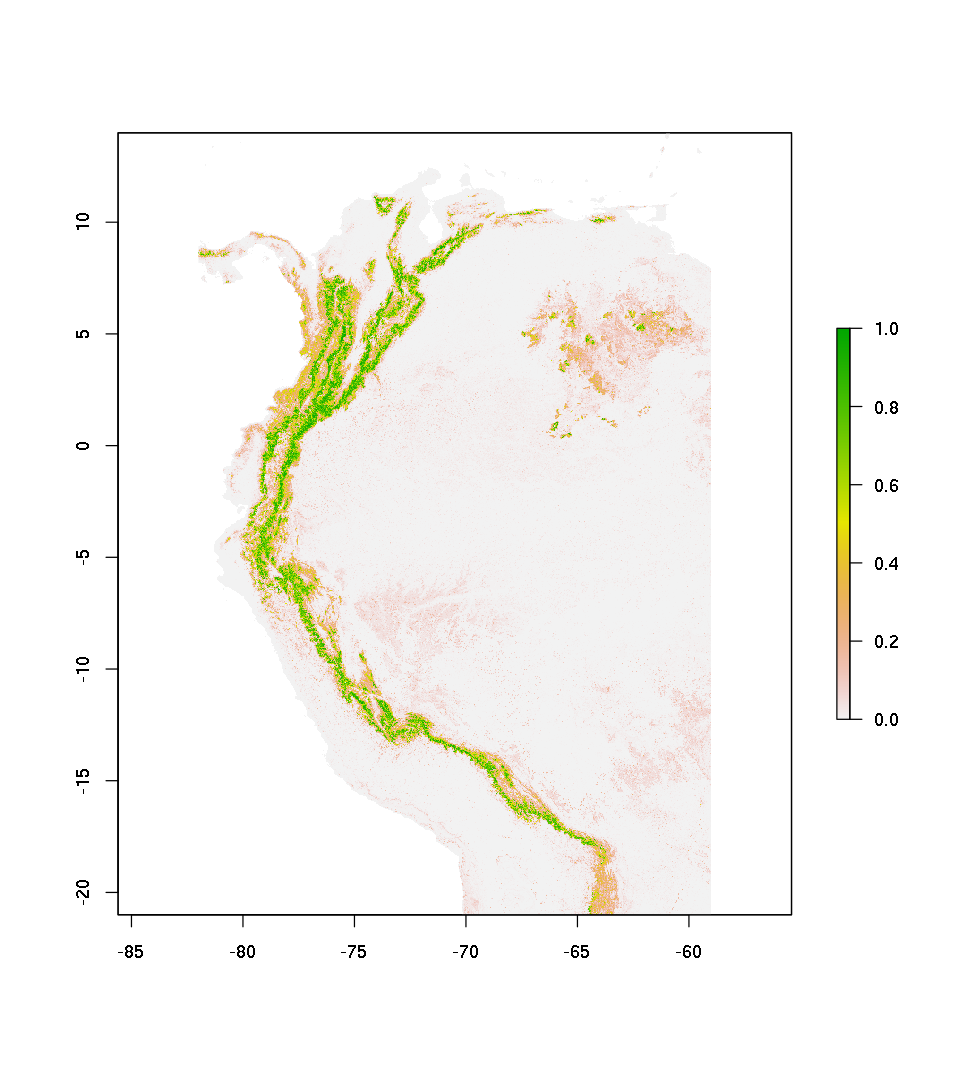

In [65]:
plot(pred.rf.prob1)
plot(pred.rf.prob0)

### Predict occurence presence

Create a raste with 10 km resoultion (0.083333333333)

In [50]:
occ = raster(nrows=420, ncols=276, xmn=-82, xmx=-59, ymn=-21, ymx=14, crs="+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0" , vals=0)

In [51]:
occ

class      : RasterLayer 
dimensions : 420, 276, 115920  (nrow, ncol, ncell)
resolution : 0.08333333, 0.08333333  (x, y)
extent     : -82, -59, -21, 14  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : memory
names      : layer 
values     : 0, 0  (min, max)


In [52]:
pointcount = function(r, pts){
  # make a raster of zeroes like the input
  r2 = r
  r2[] = 0
  # get the cell index for each point and make a table:
  counts = table(cellFromXY(r,pts))
  # fill in the raster with the counts from the cell index:
  r2[as.numeric(names(counts))] = counts
  return(r2)
 }

occ_raster <- pointcount(occ, points)

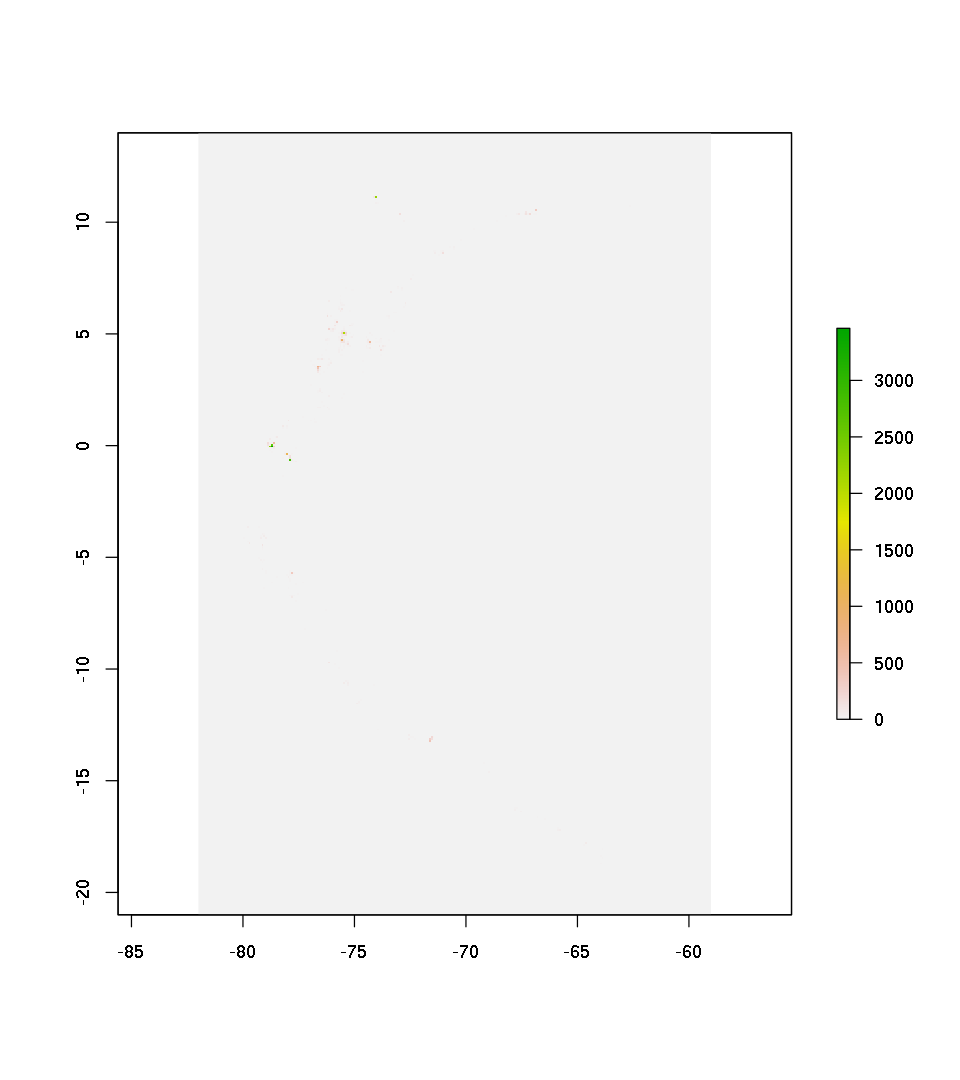

In [53]:
plot(occ_raster)

In [54]:
occ_point = rasterToPoints(occ_raster , spatial=TRUE)

In [55]:
str(occ_point)

Formal class 'SpatialPointsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	115920 obs. of  1 variable:
  .. ..$ layer: num [1:115920] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ coords.nrs : num(0) 
  ..@ coords     : num [1:115920, 1:2] -82 -81.9 -81.8 -81.7 -81.6 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:2] "x" "y"
  ..@ bbox       : num [1:2, 1:2] -82 -21 -59 14
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:2] "x" "y"
  .. .. ..$ : chr [1:2] "min" "max"
  ..@ proj4string:Formal class 'CRS' [package "sp"] with 1 slot
  .. .. ..@ projargs: chr "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"


Sampling the occurrence points by eliminating the extremes.

In [56]:
occ_point_sel = subset(occ_point , (layer > 0 & layer < 100)  )

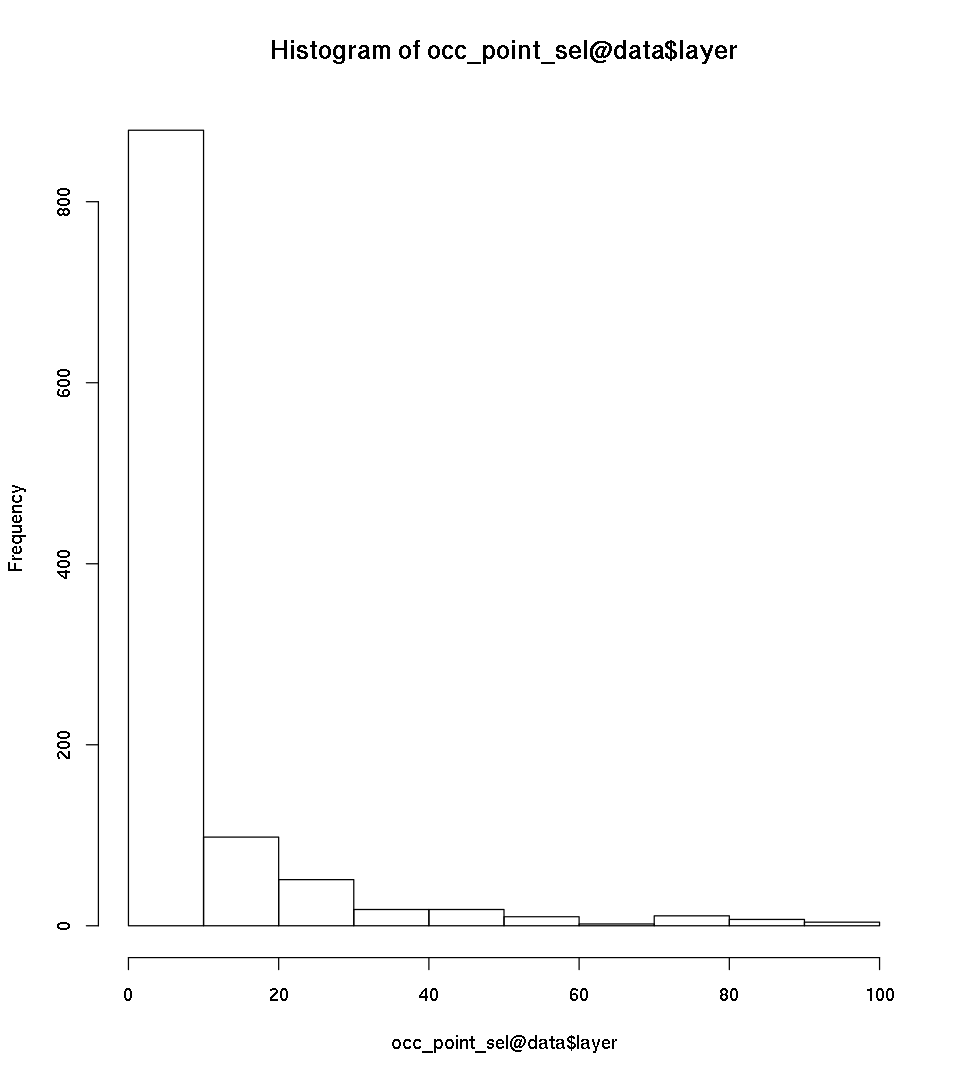

In [57]:
hist(occ_point_sel@data$layer)

In [58]:
occ_point_sel_predictor <- raster::extract(senv,occ_point_sel,sp=T) 
str(occ_point_sel_predictor)

Formal class 'SpatialPointsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	1098 obs. of  5 variables:
  .. ..$ layer : num [1:1098] 1 3 1 80 12 1 1 1 1 1 ...
  .. ..$ cld   : num [1:1098] -0.862 -0.801 -0.508 1.267 1.043 ...
  .. ..$ cld_ia: num [1:1098] 2.7755 2.6462 -0.0699 0.0876 0.3247 ...
  .. ..$ elev  : num [1:1098] -0.4921 -0.5087 -0.493 0.0657 0.4634 ...
  .. ..$ forest: num [1:1098] -1.4159 0.0819 -1.4743 0.5834 0.2877 ...
  ..@ coords.nrs : num(0) 
  ..@ coords     : num [1:1098, 1:2] -74.2 -74.1 -72.4 -74.1 -74 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:2] "x" "y"
  ..@ bbox       : num [1:2, 1:2] -81.1 -18.8 -62.6 11.2
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:2] "x" "y"
  .. .. ..$ : chr [1:2] "min" "max"
  ..@ proj4string:Formal class 'CRS' [package "sp"] with 1 slot
  .. .. ..@ projargs: chr "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"


In [59]:
mdl.rf.occ <- randomForest( layer ~ cld + cld_ia + elev + forest , data=occ_point_sel_predictor )
mdl.rf.occ


Call:
 randomForest(formula = layer ~ cld + cld_ia + elev + forest,      data = occ_point_sel_predictor) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 211.6602
                    % Var explained: 0.85

In [60]:
pred.rf.occ <- raster::predict(senv , mdl.rf.occ , type='response')

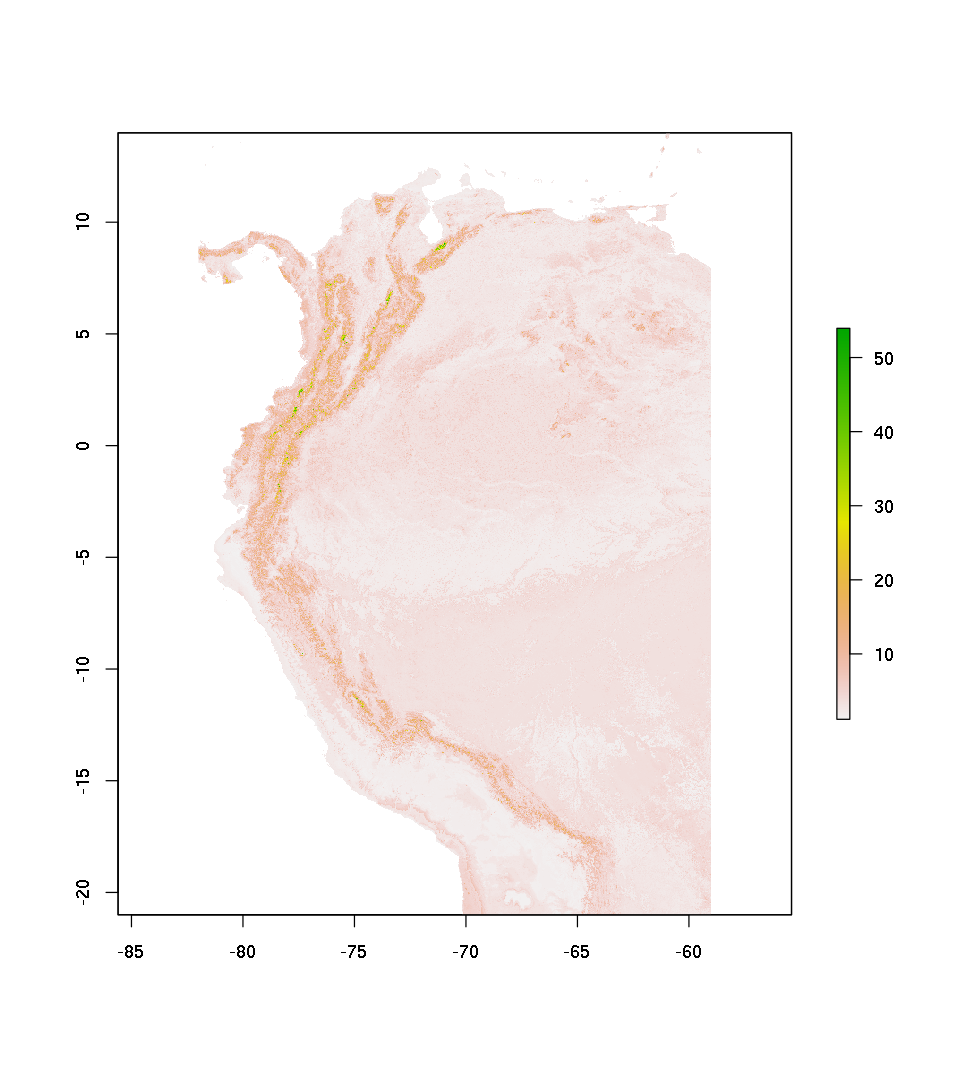

In [61]:
plot(pred.rf.occ)